<a href="https://colab.research.google.com/github/carlosfab/sigmoidal_ai/blob/master/Dados_Desbalanceados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

!pip install -q scikit-plot

# Como lidar com dados desbalanceados

Saber como lidar com dados desbalanceados pode fazer toda a diferença no no seu projeto de *Data Science* e no desempenho do seu modelo de *Machine Learning*.

Você provavelmente já se deparou com a situação de encontrar um *dataset* onde havia um nítido desequilíbrio entre as amostras de suas diferentes classes.

Alguns exemplos de situações onde o desbalanceamento é quase certo são problemas de detecção de fraude e diagnóstico médicos - é intuitivo pensar que existem mais transações lícitas que criminosas, ou que o conjunto de pessoas diagnosticadas com câncer é bem menor que o conjunto de pessoas sem a doença.

Ignorar esse fato e treinar um algoritmo em cima do conjunto de dados original, pulando uma etapa intermediária de balanceamento dos dados, pode ter impactos diretos no seu projeto de *Data Science*.

## Consequências dos dados desbalanceados

Se você está construindo um modelo de *machine learning* para classificação, por exemplo, a consequência desse desequilíbrio é que o modelo terá uma tendência a dar muitos "alarmes falsos".

Ou seja, na prática ele irá responder muito bem entradas para as classes majoritárias, mas terá um desempenho inferior para as minoriárias.

No exemplo de detecção de fraude com cartões de crédito (onde o número de transações financeiras normais é bem maior que o número de transações fraudulentas), um classificador tenderá a apresentar muitos falsos negativos - uma situação indesejável para um banco, obviamente.

Em um *trade-off*, seria preferível "errar para mais" e ter uma quantidade maior de falsos positivos. Aliás, aposto que você já teve seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito, não é mesmo?!

Teoricamente, um *dataset* que possua qualquer classe com mais de 50% das entradas já é considerado desbalanceado. No entanto, há situações extremas onde você vai encontrar proporções maiores que 99:1.

Existem várias abordagens para lidar com dados desbalanceados, cada uma com seus prós e contras. Neste artigo, irei mostrar alguns dos métodos mais populares para você incluir desde já no seu arsenal.

## Métodos para lidar com *datasets* desbalanceados

Há diversas maneiras para atacar o problema de dados desbalanceados, que envolvem desde a construção de algoritmos específicos até  a aplicação de algoritmos mais avançados como *Recognition-based Learning* e *Cost-sensitive Learning*. 

No entanto, uma outra abordagem bem mais simples tem sido amplamente usada (com ótimos resultados), a abordagem *sampling*.

*Sampling* é um pré-processamento que visa minimizar as discrepâncias entre as classes por meio de uma reamostragem do *dataset* original. Para gerar um conjunto balanceado, são usadas normalmente as seguintes técnicas:

* ***Over-sampling:*** cria novas observações da classe minoritária a partir das informações contidas nos dados originais. Essa geração de novas entradas pode ser feita aleatoriamente com o auxílio de técnicas de *clustering* ou sinteticamente.

* ***Under-sampling:*** reduz o desbalanceamento do *dataset* focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.

Além dessas duas técnicas de *sampling*, [existem também os *advanced sampling methods*](https://towardsdatascience.com/a-deep-dive-into-imbalanced-data-over-sampling-f1167ed74b5), como SMOTE e ADASYN, onde instâncias são adicionadas ou removidas adaptativamente. 

Caso tenha curiosidade em conhecer mais e se aprofundar no assunto, [recomendo o este artigo científico](https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=1806&context=infopapers).

## Vantagens e desvantagens de cada técnica

[O Teorema *No Free Lunch*](https://www.kdnuggets.com/2019/09/no-free-lunch-data-science.html) diz que não existem um perfeito e único, apenas com vantagens. Cada escolha uma renúncia, isso é *Data Science*. Quando você opta por uma abordagem, tem que estar ciente das limitações e implicações nos seus resultados -  e transmitir isso para os *stakeholders*.

*Over-sampling* replica os dados já existentes, aumentando o número de instâncias das classes minoritárias. A vantagem é que nenhuma informação é descartada, porém o custo computacional será elevado e você irá deteriorar a performance do algoritmo para as classes minoritárias.

Já o *Under-sampling* vai extrair um subconjunto aleatório da classe majoritária, preservando as características da classe minoritária, sendo ideal para situações onde você tem grandes volumes de dados. Apesar de reduzir o tempo computacional e de armazenamento, esta técnica descarta informações da classe majoritária, o que pode levar a uma performance inferior nas predições dela.


## Balanceando dados na prática

Para mostrar como balancear um *dataset* na prática, vou usar dados públicos de transações financeiras disponibilizados por empresas de cartões de crédito [neste link](https://www.kaggle.com/mlg-ulb/creditcardfraud).

Como é característico desse tipo de problema, as instâncias possuem distribuições bem discrepantes entre as classes `normal` (0) e `fraude` (1).

In [2]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Acima, importei todas as bibliotecas que serão usadas neste artigo. Na sequência, importei o arquivo `csv` para dentro de um estrutura *dataframe* do `pandas` e imprimir a contagem de valores únicos para os *labels*.

Representando 0,17% do total de instâncias, é nítida a discrepância e desbalanceamento dos dados. Mal conseguimos ver a barra da nossa variável alvo para instâncias de fraude (`df.Class == 1`).

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



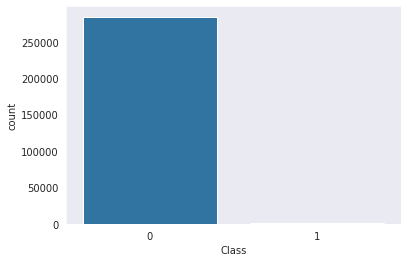

In [3]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

# ver o balanceamento das classes
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# plotar gráfico de barras para as Classes
sns.countplot('Class', data=df);

Para você ter um ideia real das consequências dessa situação, vou construir dois modelos de Regressão Logística.

No nosso primeiro modelo, separei as variáveis `X` e `y` normalmente e dividi entre conjuntos de treino e teste, como é praxe em *machine learning*. Sem maiores ajustes, treinei o modelo usando o método `fit(X_train, y_train)` e fiz a previsão de valores em cima do conjunto de teste (`X_test`).

Na sequência, plotei a matriz de confusão e o relatório de classificação.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9994    0.9995    0.9994     71079
           1     0.6875    0.6260    0.6553       123

    accuracy                         0.9989     71202
   macro avg     0.8434    0.8128    0.8274     71202
weighted avg     0.9988    0.9989    0.9988     71202

Acurácia: 0.9989

AUC: 0.8128



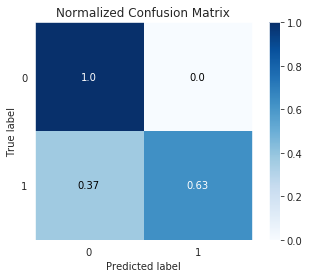

In [4]:
# separar variáveis entre X e y
X = df.drop('Class', axis=1)
y = df['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

# instanciar e treinar um modelo de Regressão Logística
model = LogisticRegression()
model.fit(X_train, y_train)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Conseguimos uma acurácia de 99,88% no nosso modelo de *machine learning*. **Você considera esse um bom resultado?**

Bem,  acurácia global foi alta, mas o que dizer daquele fator que mais importava para nós, a **capacidade de detectar fraudes no cartão de crédito?**

Aí é outra história... por causa do desbalanceamento de dados, o modelo foi capaz de classificar bem as instâncias onde `df.Class == 0` (transações normais), mas acertou menos de 60% dos casos em que `df.Class == 1`.

Vamos ver agora qual seria o resultado caso tivessemos usado a técnica ***Under-sampling***. Para facilitar esse pré-processamento, vou usar a biblioteca `imblearn` com sua classe `imblearn.under_sampling.RandomUnderSampler` e chamar o método `fit_sample(X_train, y_train)`.

Note como eu estou usando o *under-sampling* em cima do conjunto de treino, e não de todos os dados. Isso é muito importante para não desconfigurarmos a característica de teste original do *dataset*.

1    369
0    369
dtype: int64


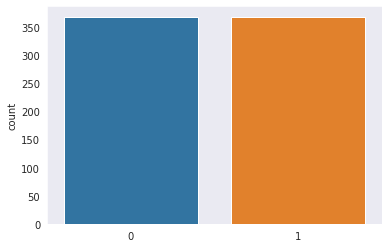

In [5]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_res, y_res = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_res);

O novo conjunto está corretamente balanceado agora, eliminando boa parte do problema que tínhamos inicialmente.

Novamente, vou instanciar um novo modelo de Regressão Logística e treiná-lo nesses dados balanceados. Vamos dar uma olhada nas métricas de avaliação que foram usadas, e ver o que mudou.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9671    0.9832     71079
           1     0.0473    0.9431    0.0900       123

    accuracy                         0.9671     71202
   macro avg     0.5236    0.9551    0.5366     71202
weighted avg     0.9983    0.9671    0.9817     71202

Acurácia: 0.9671

AUC: 0.9551



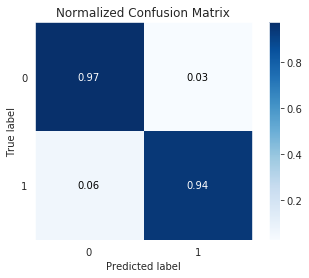

In [6]:
# instanciar e treinar um modelo de Regressão Logística
model_res = LogisticRegression()
model_res.fit(X_res, y_res)

# fazer as previsões em cima dos dados de teste
y_pred_res = model_res.predict(X_test)
y_proba_res = model_res.predict_proba(X_test)

# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_res, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_res, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_res)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_res)))

Repare que apesar da acurácia ter diminuído minimamente, tivemos um aumento significativo na capacidade do modelo em detectar fraudes. 

Apenas pelo fato de balancearmos os dados, melhoramos diversos parâmetros como `recall` e a área sob a curva (AUC), que são métricas extremamente importantes para o problema que estamos lidando.

## Balanceamento de dados no mundo real

São diversos os motivos que permitem que os dados sejam desbalanceados. Pode ser que o cientista de dados não conseguiu coletar igualmente dados de cada classe, ou pode ser que a amostra realmente refleta a população.

Independente dos motivos, o não tratamente desse desbalanceamento afeta negativamente o desempenho do modelo, refletindo na qualidade global do seu projeto de *Data Science*.

Não existe um método universal e ótimo. Existem técnicas que evoluem constantemente, e cabe a você identificar os prós e contras de cada uma.

Por isso, recomendo não acompanhar apenas sites como o Kaggle, mas também acompanhar *papers* e trabalhos acadêmicos que tragam pesquisas nessa área tão importante.